# Grupowanie połączonych danych anxiety + depression, ale wciąż dla pojedynczych osób, bez danych z users

# Wczytanie danych:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics, datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

#Zbiór danych users
users = pd.read_csv('ausers.csv', delimiter=';')
#print(users.head(50))

In [2]:
anxiety = pd.read_csv('aanxiety.csv', delimiter=';')
print(anxiety.head(5))

duplicates = anxiety.duplicated().sum()
#print(f"Duplikaty: {duplicates}")

            attributes              date email gender
0  3|3|2|3|3|2|0|2|3|0  2021-11-13 14:52  ID13      M
1  2|2|2|1|2|2|0|1|1|1  2021-11-13 14:52  ID48      M
2  3|3|1|2|2|2|2|1|1|1  2021-11-13 15:03   ID6      M
3  2|2|2|2|2|2|1|2|2|2  2021-11-13 15:04   ID5      K
4  1|1|1|1|1|1|0|1|1|2  2021-11-13 15:04  ID34      M


In [3]:
depression = pd.read_csv('adepression.csv', delimiter=';')
print(anxiety.head(5))

duplicates = depression.duplicated().sum()
#print(f"Duplikaty: {duplicates}")

            attributes              date email gender
0  3|3|2|3|3|2|0|2|3|0  2021-11-13 14:52  ID13      M
1  2|2|2|1|2|2|0|1|1|1  2021-11-13 14:52  ID48      M
2  3|3|1|2|2|2|2|1|1|1  2021-11-13 15:03   ID6      M
3  2|2|2|2|2|2|1|2|2|2  2021-11-13 15:04   ID5      K
4  1|1|1|1|1|1|0|1|1|2  2021-11-13 15:04  ID34      M


# Usuwanie wierszy:

Do usuwania numery wierszy -2 w stosunku do csv
Powtarzające się ID w aanixiety: 
- ID83 - ponad rok różnicy, zostawione oba
- ID76 - -//-
- ID86 - mniej niż godzina różnicy, wywalić wiersz nr 41 (albo 40 bez nagłówka)
- ID82 - ponad rok różnicy, zostawione oba
- ID215 - ponad dzień różnicy, zostawione oba
- ID162 - mniej niż godzina różnicy, wywalić wiersz nr 70 (albo 69 bez nagłówka)
- ID212 - parę godzin ponad dzień różnicy, więc zostawione oba???
- ID174 - wywalić wiersz nr 93 (92 bez nagłówka)
- ID214 - 22h różnicy??? - zatwierdzone - oba zostawić!!!
- ID129 - kilka dni różnicy, zostawione oba

W adepression: 
Pierwsze dwa tak samo.
ID86 nie istnieje???
- ID82 - mniej niż godzina różnicy, wywalić wiersz nr 36 (albo 35 bez nagłówka)
- ID212 - parę godzin ponad dzień różnicy, więc zostawione oba???
- ID174 - wywalić wiersz 70

In [4]:
do_usuniecia_anxiety = [39, 68, 91]
do_usuniecia_depression = [34, 68]

anxiety = anxiety.drop(anxiety.index[do_usuniecia_anxiety])
anxiety = anxiety.reset_index(drop=True)

depression = depression.drop(depression.index[do_usuniecia_depression])
depression = depression.reset_index(drop=True)

# Przygotowanie danych: 

In [5]:
# Przygotowanie atrybutów anxiety:
anxiety_split = anxiety['attributes'].str.split('|', expand=True)
anxiety_split.columns = [f'f_{i}' for i in range(anxiety_split.shape[1])]
anxiety = pd.concat([anxiety_split, anxiety['date'], anxiety['email'], anxiety['gender']], axis=1)
print(anxiety.head(5))

  f_0 f_1 f_2 f_3 f_4 f_5 f_6 f_7 f_8 f_9              date email gender
0   3   3   2   3   3   2   0   2   3   0  2021-11-13 14:52  ID13      M
1   2   2   2   1   2   2   0   1   1   1  2021-11-13 14:52  ID48      M
2   3   3   1   2   2   2   2   1   1   1  2021-11-13 15:03   ID6      M
3   2   2   2   2   2   2   1   2   2   2  2021-11-13 15:04   ID5      K
4   1   1   1   1   1   1   0   1   1   2  2021-11-13 15:04  ID34      M


In [6]:
# Przygotowanie atrybutów depression:
d_split = depression['attributes'].str.split('|', expand=True)
d_split.columns = [f'f_{i}' for i in range(d_split.shape[1])]
depression = pd.concat([d_split, depression['date'], depression['email'], depression['gender']], axis=1)
print(depression.head(5))

  f_0 f_1 f_2 f_3 f_4 f_5 f_6 f_7 f_8 f_9              date email gender
0   1   1   0   3   2   1   2   0   2   1  2021-11-13 14:52  ID13      M
1   1   1   1   1   1   0   1   1   0   1  2021-11-13 14:52  ID48      M
2   1   1   0   1   1   1   1   1   1   1  2021-11-13 15:03   ID6      M
3   1   1   1   1   0   1   1   1   1   1  2021-11-13 15:04  ID34      M
4   2   0   0   1   2   2   1   1   2   2  2021-11-13 15:04   ID5      K


In [7]:
featuresA = anxiety.iloc[:,0:10] #cechy do grupowania
featuresA = featuresA.rename(columns=lambda x: f"{x}_a") #Zmiana nazwy, żeby można było rozróżnić cechy
featuresD = depression.iloc[:,0:10] 
featuresD = featuresD.rename(columns=lambda x: f"{x}_d")

all_features = pd.concat([featuresA, featuresD], axis=1)
indexes = []

for i in range(len(all_features)):
    if all_features.iloc[i].isna().any():
        indexes.append(i)
        
all_features = all_features.drop(all_features.index[indexes])    
all_features = all_features.reset_index(drop=True)
print(all_features)

   f_0_a f_1_a f_2_a f_3_a f_4_a f_5_a f_6_a f_7_a f_8_a f_9_a f_0_d f_1_d  \
0      3     3     2     3     3     2     0     2     3     0     1     1   
1      2     2     2     1     2     2     0     1     1     1     1     1   
2      3     3     1     2     2     2     2     1     1     1     1     1   
3      2     2     2     2     2     2     1     2     2     2     1     1   
4      1     1     1     1     1     1     0     1     1     2     2     0   
..   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
88     1     1     1     1     1     1     0     0     1     1     1     1   
89     1     1     2     1     0     0     0     0     2     1     2     2   
90     2     1     2     1     1     1     1     1     2     2     1     2   
91     2     2     2     2     1     1     1     1     0     1     0     0   
92     3     1     2     1     1     1     1     2     1     2     2     2   

   f_2_d f_3_d f_4_d f_5_d f_6_d f_7_d f_8_d f_9_d  
0      0  

# Grupowanie KMeans

In [8]:
kmeans = KMeans(n_clusters=2, #Liczba skupień
                init='k-means++',
                n_init=10,
                max_iter=300, #Maksymalna liczba iteracji algorytmu
                random_state=0, #Ustawienie ziarna generatora liczb pseudo-losowych                
               )

kmeans.fit(all_features) #Grupowanie

inertia = kmeans.inertia_
print("Miara jakości = ", inertia);

centroids = kmeans.cluster_centers_
print("Centroidy: \n", centroids)

clusters = kmeans.fit_predict(all_features)

Miara jakości =  976.5564292321924
Centroidy: 
 [[2.26086957 1.69565217 1.93478261 1.7173913  1.54347826 1.43478261
  0.73913043 1.91304348 1.73913043 1.52173913 0.67391304 0.84782609
  0.7826087  1.54347826 1.04347826 0.73913043 1.         0.7173913
  0.97826087 0.89130435]
 [1.29787234 0.61702128 0.91489362 0.87234043 0.53191489 0.61702128
  0.04255319 0.70212766 0.65957447 0.74468085 0.78723404 0.78723404
  0.72340426 1.4893617  1.17021277 0.78723404 1.06382979 0.74468085
  1.10638298 1.04255319]]


In [9]:
#Dla 3 klastrów
kmeans3 = KMeans(n_clusters=3, #Liczba skupień
                init='k-means++',
                n_init=10,
                max_iter=300, #Maksymalna liczba iteracji algorytmu
                random_state=0, #Ustawienie ziarna generatora liczb pseudo-losowych                
               )

kmeans3.fit(all_features) #Grupowanie

inertia3 = kmeans3.inertia_
print("Miara jakości = ", inertia3);

centroids3 = kmeans3.cluster_centers_
print("Centroidy: \n", centroids3)

clusters3 = kmeans3.fit_predict(all_features)

Miara jakości =  838.4776714513557
Centroidy: 
 [[2.54545455 1.72727273 2.18181818 1.95454545 1.5        1.54545455
  0.72727273 2.22727273 2.22727273 1.72727273 0.90909091 1.27272727
  1.09090909 2.36363636 1.59090909 1.         1.27272727 1.
  1.45454545 1.31818182]
 [1.24242424 0.57575758 0.87878788 0.84848485 0.57575758 0.54545455
  0.03030303 0.63636364 0.51515152 0.84848485 1.12121212 0.87878788
  0.87878788 1.78787879 1.45454545 1.06060606 1.3030303  1.06060606
  1.42424242 1.33333333]
 [1.78947368 1.31578947 1.44736842 1.28947368 1.15789474 1.13157895
  0.5        1.34210526 1.18421053 1.02631579 0.28947368 0.5
  0.44736842 0.78947368 0.52631579 0.36842105 0.65789474 0.28947368
  0.47368421 0.44736842]]


# Optymalizacja skupień metodą łokcia

*** Eksperyment numer: 1 Jakość =  1193.763440860215
*** Eksperyment numer: 2 Jakość =  976.5564292321924
*** Eksperyment numer: 3 Jakość =  838.4776714513557
*** Eksperyment numer: 4 Jakość =  768.216106442577
*** Eksperyment numer: 5 Jakość =  721.6814832535886
*** Eksperyment numer: 6 Jakość =  698.6936507936507
*** Eksperyment numer: 7 Jakość =  660.3023504273505
*** Eksperyment numer: 8 Jakość =  636.0185394670689
*** Eksperyment numer: 9 Jakość =  616.5750360750361


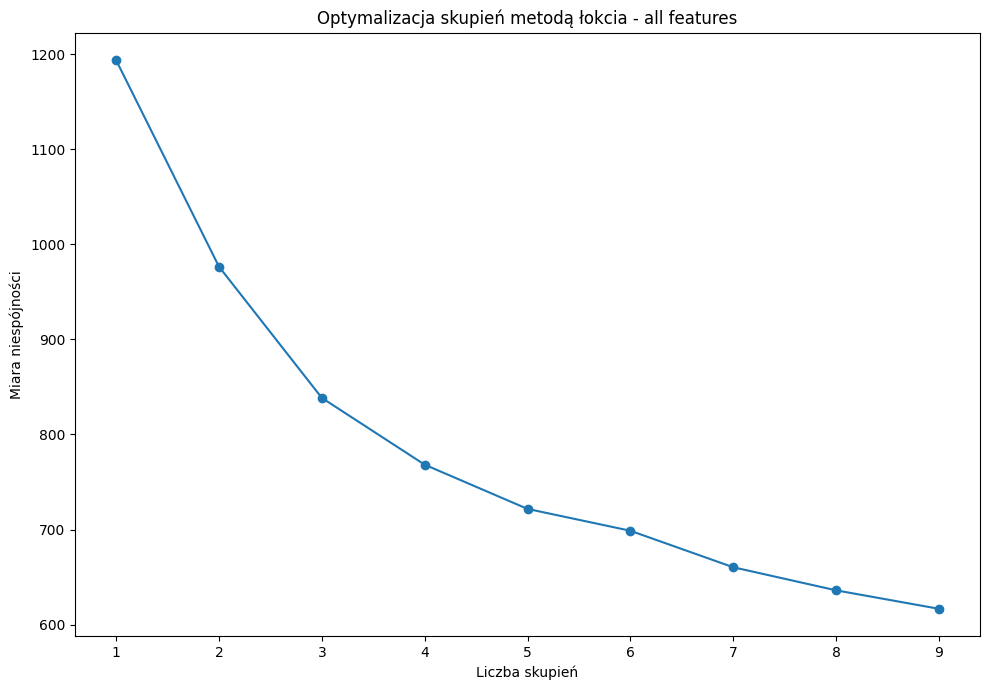

In [10]:
results = []
n = 10 #Liczba eksperymentów
for k in range(1, n):
        
    #Utworzenie obiektu do grupowania    
    kmeans = KMeans(n_clusters=k,init='k-means++',n_init=10,max_iter=300,random_state=0)
    kmeans.fit(all_features)
    
    #Obliczenie jakości grupowania
    #Miara niespójności skupień: suma kwadratów odległości obiektów do środka najbliższego skupienia
    inertia = kmeans.inertia_ #Powinna być jak najmniejsza
    
    results.append(inertia)
    
    print("*** Eksperyment numer: " + str(k) + " Jakość = ", inertia)

#Na podstawie poniższego wykresu wybieramy takie k, które jest bliskie punktu przegięcia 

fig = plt.figure(figsize=(10, 7))
plt.plot(range(1,n), results , marker='o')
plt.title("Optymalizacja skupień metodą łokcia - all features")
plt.xlabel('Liczba skupień')
plt.ylabel('Miara niespójności')
plt.tight_layout()
plt.show()

# Miara Silhouette

In [11]:
from sklearn.metrics import silhouette_score
clusters = kmeans.fit_predict(all_features)

silhouette_avg = silhouette_score(all_features, clusters)
print(f"Średnia wartość silhouette dla wszystkich cech, liczba skupień 2: {silhouette_avg:.3f}")

silhouette_avg3 = silhouette_score(all_features, clusters3)
print(f"Średnia wartość silhouette dla wszystkich cech, liczba skupień 3: {silhouette_avg3:.3f}")

Średnia wartość silhouette dla wszystkich cech, liczba skupień 2: 0.155
Średnia wartość silhouette dla wszystkich cech, liczba skupień 3: 0.149


*** Eksperyment numer: 2 Jakość =  0.15526083434817128
*** Eksperyment numer: 3 Jakość =  0.14851521120824446
*** Eksperyment numer: 4 Jakość =  0.12174923164613835
*** Eksperyment numer: 5 Jakość =  0.10765594803411892
*** Eksperyment numer: 6 Jakość =  0.09831683549261604
*** Eksperyment numer: 7 Jakość =  0.10259128195794526
*** Eksperyment numer: 8 Jakość =  0.08915818092437988
*** Eksperyment numer: 9 Jakość =  0.0840695279950697


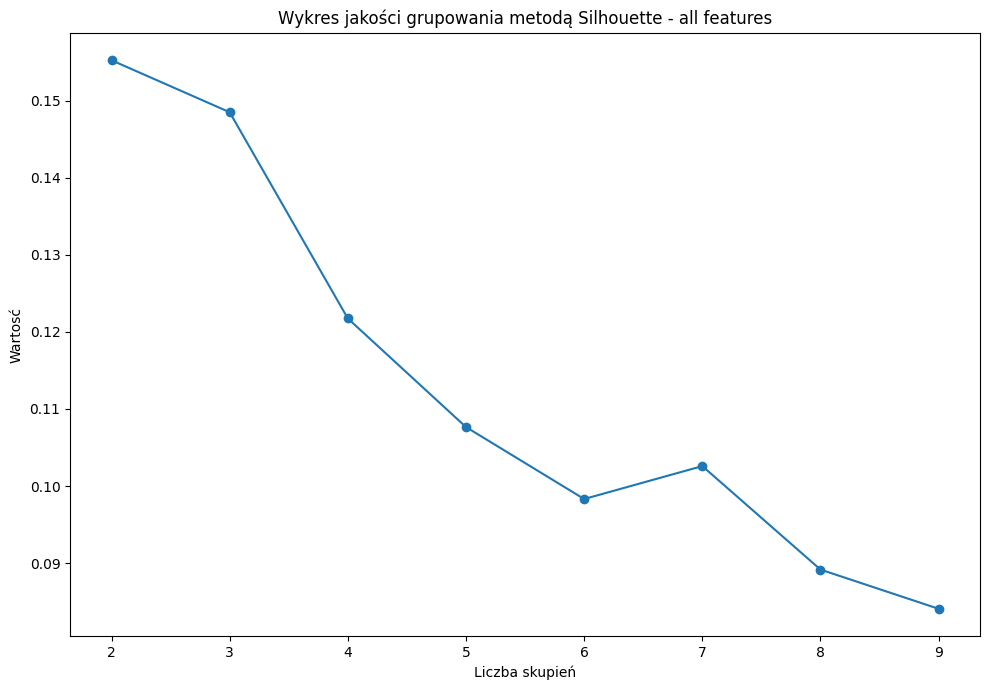

In [12]:
results = []
for k in range(2, 10):
        
    #Utworzenie obiektu do grupowania    
    kmeans = KMeans(n_clusters=k,init='k-means++',n_init=10,max_iter=300,random_state=0)

    kmeans.fit(all_features)
    clusters = kmeans.predict(all_features)
    #Obliczenie jakości grupowania
    silhouette_avg = silhouette_score(all_features, clusters) #Powinna być jak najbliższa 1, ale broń Boże nie poniżej 0
    results.append(silhouette_avg)
    
    print("*** Eksperyment numer: " + str(k) + " Jakość = ", silhouette_avg)

fig = plt.figure(figsize=(10, 7))
plt.plot(range(2,n), results , marker='o')
plt.title("Wykres jakości grupowania metodą Silhouette - all features")
plt.xlabel('Liczba skupień')
plt.ylabel('Wartosć')
plt.tight_layout()
plt.show()

# Indeks Davies - Bouldin

In [15]:
# Obliczenie indeksu Davies-Bouldin
from sklearn.metrics import davies_bouldin_score
clusters = kmeans.fit_predict(all_features)

dbi = davies_bouldin_score(all_features, clusters)
print(f"Indeks Davies-Bouldin, liczba skupień 2: {dbi:.3f}")

dbi3 = davies_bouldin_score(all_features, clusters3)
print(f"Indeks Davies-Bouldin, liczba skupień 3: {dbi3:.3f}")

Indeks Davies-Bouldin, liczba skupień 2: 2.140
Indeks Davies-Bouldin, liczba skupień 3: 1.820


*** Eksperyment numer: 2 Jakość =  2.060634150422384
*** Eksperyment numer: 3 Jakość =  1.8202190531470113
*** Eksperyment numer: 4 Jakość =  1.8336917738716054
*** Eksperyment numer: 5 Jakość =  2.011249731443207
*** Eksperyment numer: 6 Jakość =  1.9025580197989234
*** Eksperyment numer: 7 Jakość =  1.9615779882871904
*** Eksperyment numer: 8 Jakość =  2.022481001875799
*** Eksperyment numer: 9 Jakość =  2.140220963398202


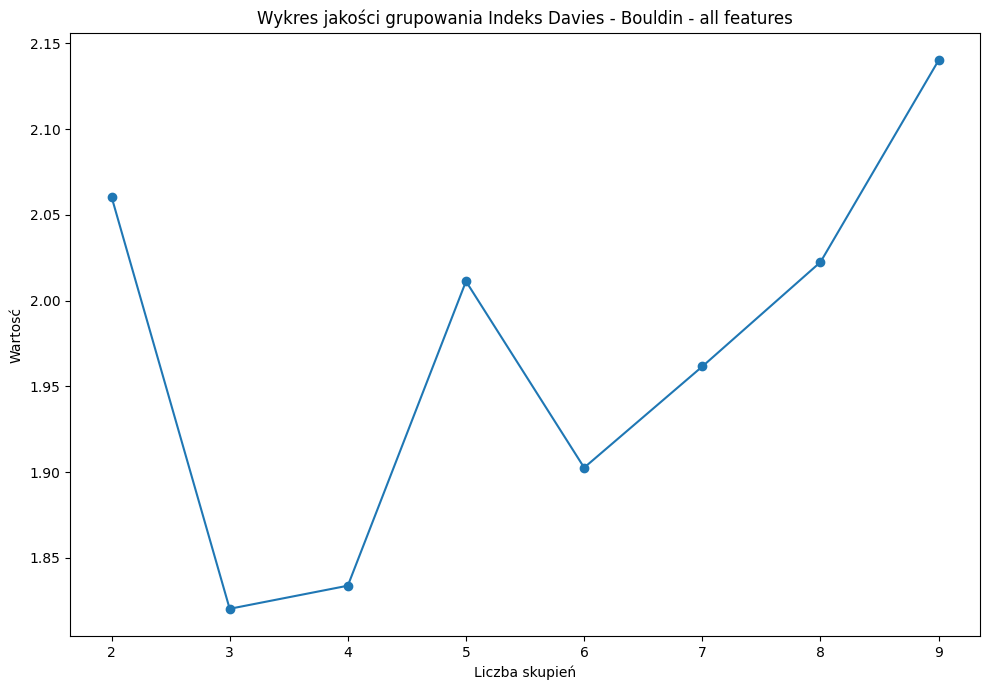

In [14]:
results = []
for k in range(2, 10):
        
    #Utworzenie obiektu do grupowania    
    kmeans = KMeans(n_clusters=k,init='k-means++',n_init=10,max_iter=300,random_state=0)

    kmeans.fit(all_features)
    clusters = kmeans.predict(all_features)
    #Obliczenie jakości grupowania
    dbi = davies_bouldin_score(all_features, clusters)
    results.append(dbi)
    
    print("*** Eksperyment numer: " + str(k) + " Jakość = ", dbi)

fig = plt.figure(figsize=(10, 7))
plt.plot(range(2,n), results , marker='o')
plt.title("Wykres jakości grupowania Indeks Davies - Bouldin - all features")
plt.xlabel('Liczba skupień')
plt.ylabel('Wartosć')
plt.tight_layout()
plt.show()

# Miara Calinski-Harabasz

In [16]:
from sklearn.metrics import calinski_harabasz_score
clusters = kmeans.fit_predict(all_features)

ch_score = calinski_harabasz_score(all_features, clusters)
print("Calinski-Harabasz score, liczba skupień 2:", ch_score)

ch_score3 = calinski_harabasz_score(all_features, clusters3)
print("Calinski-Harabasz score, liczba skupień 3:", ch_score3)

Calinski-Harabasz score, liczba skupień 2: 9.829263099628362
Calinski-Harabasz score, liczba skupień 3: 19.067722573607266


*** Eksperyment numer: 2 Jakość =  20.240343994960693
*** Eksperyment numer: 3 Jakość =  19.067722573607266
*** Eksperyment numer: 4 Jakość =  16.433619153753405
*** Eksperyment numer: 5 Jakość =  14.391117561341616
*** Eksperyment numer: 6 Jakość =  12.329029092182642
*** Eksperyment numer: 7 Jakość =  11.579961247433125
*** Eksperyment numer: 8 Jakość =  10.648457929306293
*** Eksperyment numer: 9 Jakość =  9.829263099628362


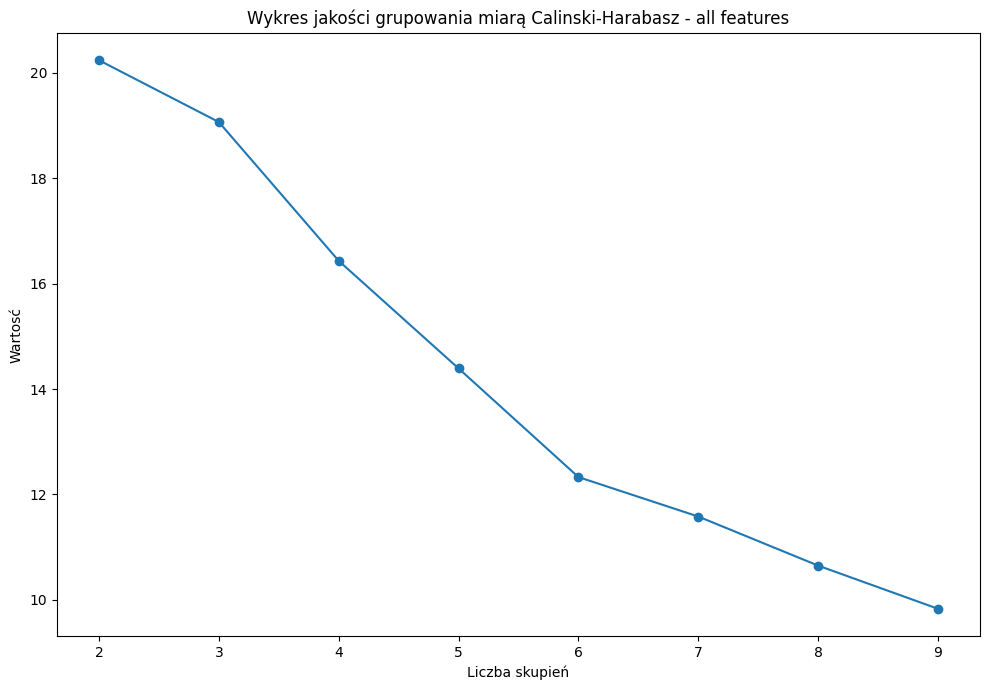

In [17]:
results = []
for k in range(2, 10):
        
    #Utworzenie obiektu do grupowania    
    kmeans = KMeans(n_clusters=k,init='k-means++',n_init=10,max_iter=300,random_state=0)

    kmeans.fit(all_features)
    clusters = kmeans.predict(all_features)
    #Obliczenie jakości grupowania
    ch_score = calinski_harabasz_score(all_features, clusters)
    results.append(ch_score)
    
    print("*** Eksperyment numer: " + str(k) + " Jakość = ", ch_score)

fig = plt.figure(figsize=(10, 7))
plt.plot(range(2,n), results , marker='o')
plt.title("Wykres jakości grupowania miarą Calinski-Harabasz - all features")
plt.xlabel('Liczba skupień')
plt.ylabel('Wartosć')
plt.tight_layout()
plt.show()

# Wizualizacja skupień 
Metoda PCA

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


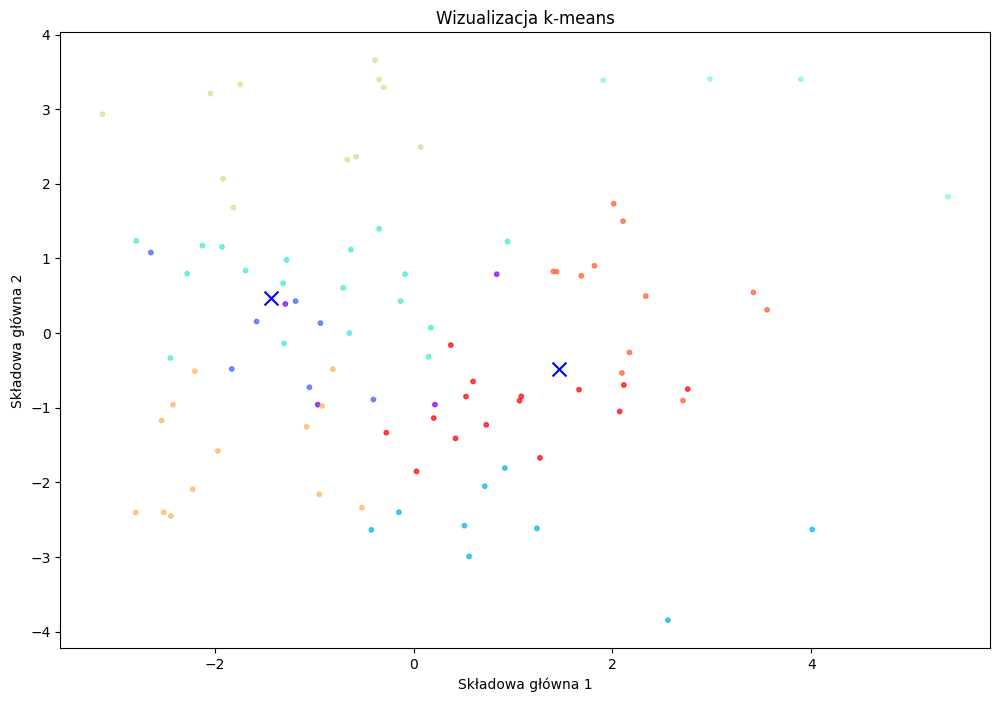

In [81]:
clusters = kmeans.fit_predict(all_features)

#Redukcja wymiarów za pomocą PCA - dane są sprowadzane do 2 wymiarów
pca = PCA(n_components=2)
features_pca = pca.fit_transform(all_features)
centroids_pca = pca.transform(centroids)

plt.figure(figsize=(12, 8))
plt.title('Wizualizacja k-means')
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clusters, cmap='rainbow', s=10, alpha=0.7)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=100, color='blue', marker='x')
plt.xlabel('Składowa główna 1')
plt.ylabel('Składowa główna 2')
plt.show()

# Grupowanie metodą hierarchiczną

In [82]:
ac = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='complete')
ac.fit(all_features)

print(len(all_features))

clustersHierarchy = ac.fit_predict(all_features)

for i in range(0,len(clusters)):
    print("Obiekt numer:"+str(i)," Skupienie:"+str(clustersHierarchy[i]))

93
Obiekt numer:0  Skupienie:2
Obiekt numer:1  Skupienie:0
Obiekt numer:2  Skupienie:1
Obiekt numer:3  Skupienie:1
Obiekt numer:4  Skupienie:0
Obiekt numer:5  Skupienie:1
Obiekt numer:6  Skupienie:1
Obiekt numer:7  Skupienie:0
Obiekt numer:8  Skupienie:1
Obiekt numer:9  Skupienie:0
Obiekt numer:10  Skupienie:1
Obiekt numer:11  Skupienie:2
Obiekt numer:12  Skupienie:0
Obiekt numer:13  Skupienie:1
Obiekt numer:14  Skupienie:0
Obiekt numer:15  Skupienie:0
Obiekt numer:16  Skupienie:0
Obiekt numer:17  Skupienie:0
Obiekt numer:18  Skupienie:2
Obiekt numer:19  Skupienie:0
Obiekt numer:20  Skupienie:1
Obiekt numer:21  Skupienie:1
Obiekt numer:22  Skupienie:0
Obiekt numer:23  Skupienie:0
Obiekt numer:24  Skupienie:0
Obiekt numer:25  Skupienie:0
Obiekt numer:26  Skupienie:1
Obiekt numer:27  Skupienie:1
Obiekt numer:28  Skupienie:1
Obiekt numer:29  Skupienie:0
Obiekt numer:30  Skupienie:0
Obiekt numer:31  Skupienie:1
Obiekt numer:32  Skupienie:0
Obiekt numer:33  Skupienie:0
Obiekt numer:34  Skup

# Wizualizacja grupowania hierarchicznego

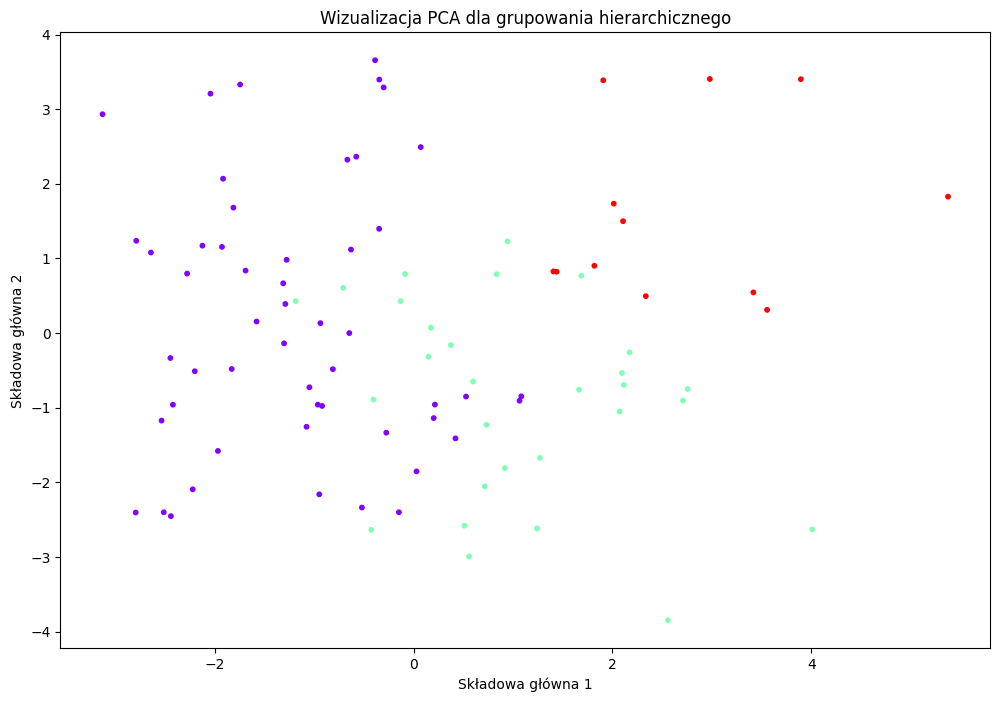

In [83]:
# Redukcja wymiarów za pomocą PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(all_features)

plt.figure(figsize=(12, 8))
plt.title('Wizualizacja PCA dla grupowania hierarchicznego')
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clustersHierarchy, s=10, alpha=0.99, cmap='rainbow')
plt.xlabel("Składowa główna 1")
plt.ylabel("Składowa główna 2")
plt.show()

# Właściwe grupowanie

In [8]:
kmeans = KMeans(n_clusters=2, #Liczba skupień
                init='k-means++',
                n_init=10,
                max_iter=300, #Maksymalna liczba iteracji algorytmu
                random_state=0, #Ustawienie ziarna generatora liczb pseudo-losowych                
               )

kmeans.fit(all_features) #Grupowanie

inertia = kmeans.inertia_
print("Miara jakości = ", inertia);

centroids = kmeans.cluster_centers_
print("Centroidy: \n", centroids)

clusters = kmeans.fit_predict(all_features)

Miara jakości =  976.5564292321924
Centroidy: 
 [[2.26086957 1.69565217 1.93478261 1.7173913  1.54347826 1.43478261
  0.73913043 1.91304348 1.73913043 1.52173913 0.67391304 0.84782609
  0.7826087  1.54347826 1.04347826 0.73913043 1.         0.7173913
  0.97826087 0.89130435]
 [1.29787234 0.61702128 0.91489362 0.87234043 0.53191489 0.61702128
  0.04255319 0.70212766 0.65957447 0.74468085 0.78723404 0.78723404
  0.72340426 1.4893617  1.17021277 0.78723404 1.06382979 0.74468085
  1.10638298 1.04255319]]


# Przypisanie grup do danych

In [11]:
# Przypisanie grup do danych - all_features
allGroups = all_features.copy()
new_column = pd.Series(clusters, name='group')
allGroups = pd.concat([allGroups, new_column], axis=1)

#print(allGroups.head(10))

#Zestawienie wszystkich grup z wszystkimi
wiersze = []

for i in range(0,len(allGroups)-1):
    for j in range(0,len(allGroups)-1):
        if i != j:
            index_i = pd.Series(allGroups.index[i], index=['index_i'])
            features_i = allGroups.iloc[i,0:20].reset_index(drop=True)
            features_i.index = [f'feature_{k}_i' for k in range(0,len(features_i))]
            group_i = pd.Series(allGroups.iloc[i,20], index=['group_i'])
            index_j = pd.Series(allGroups.index[j], index=['index_j'])
            features_j = allGroups.iloc[j,0:20].reset_index(drop=True)
            features_j.index = [f'feature_{k}_j' for k in range(0,len(features_j))]
            group_j = pd.Series(allGroups.iloc[j,20], index=['group_j'])
            wiersz = pd.concat([features_i, features_j, index_i , group_i, index_j, group_j], axis=0)
            wiersze.append(wiersz)

allFeaturesZestawienie = pd.DataFrame(wiersze)
print(allFeaturesZestawienie.head())

  feature_0_i feature_1_i feature_2_i feature_3_i feature_4_i feature_5_i  \
0           3           3           2           3           3           2   
1           3           3           2           3           3           2   
2           3           3           2           3           3           2   
3           3           3           2           3           3           2   
4           3           3           2           3           3           2   

  feature_6_i feature_7_i feature_8_i feature_9_i  ... feature_14_j  \
0           0           2           3           0  ...            1   
1           0           2           3           0  ...            1   
2           0           2           3           0  ...            0   
3           0           2           3           0  ...            2   
4           0           2           3           0  ...            1   

  feature_15_j feature_16_j feature_17_j feature_18_j feature_19_j index_i  \
0            0            1     

In [12]:
print(allGroups) #Zestawienie grup z cechami

   f_0_a f_1_a f_2_a f_3_a f_4_a f_5_a f_6_a f_7_a f_8_a f_9_a  ... f_1_d  \
0      3     3     2     3     3     2     0     2     3     0  ...     1   
1      2     2     2     1     2     2     0     1     1     1  ...     1   
2      3     3     1     2     2     2     2     1     1     1  ...     1   
3      2     2     2     2     2     2     1     2     2     2  ...     1   
4      1     1     1     1     1     1     0     1     1     2  ...     0   
..   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
88     1     1     1     1     1     1     0     0     1     1  ...     1   
89     1     1     2     1     0     0     0     0     2     1  ...     2   
90     2     1     2     1     1     1     1     1     2     2  ...     2   
91     2     2     2     2     1     1     1     1     0     1  ...     0   
92     3     1     2     1     1     1     1     2     1     2  ...     2   

   f_2_d f_3_d f_4_d f_5_d f_6_d f_7_d f_8_d f_9_d group  
0      0     3  

# Reguły decyzyjne

In [91]:
# Reguły decyzyjne
allFeaturesRules = allFeaturesZestawienie.copy()

#Zestawienie wszystkich grup z wszystkimi
rows = []

for i in range(0,len(allFeaturesRules)):
    row = allFeaturesRules.iloc[i]
    if int(row['group_i']) != int(row['group_j']): #wykluczenie wierszy, w których nie ma zmiany grupy
        wiersz = {
            'feature_0_a': f"\"{row['feature_0_i']}-{row['feature_0_j']}\"",
            'feature_1_a': f"\"{row['feature_1_i']}-{row['feature_1_j']}\"",
            'feature_2_a': f"\"{row['feature_2_i']}-{row['feature_2_j']}\"",
            'feature_3_a': f"\"{row['feature_3_i']}-{row['feature_3_j']}\"",
            'feature_4_a': f"\"{row['feature_4_i']}-{row['feature_4_j']}\"",
            'feature_5_a': f"\"{row['feature_5_i']}-{row['feature_5_j']}\"",
            'feature_6_a': f"\"{row['feature_6_i']}-{row['feature_6_j']}\"",
            'feature_7_a': f"\"{row['feature_7_i']}-{row['feature_7_j']}\"",
            'feature_8_a': f"\"{row['feature_8_i']}-{row['feature_8_j']}\"",
            'feature_9_a': f"\"{row['feature_9_i']}-{row['feature_9_j']}\"",
            'feature_0_d': f"\"{row['feature_10_i']}-{row['feature_10_j']}\"",
            'feature_1_d': f"\"{row['feature_11_i']}-{row['feature_11_j']}\"",
            'feature_2_d': f"\"{row['feature_12_i']}-{row['feature_12_j']}\"",
            'feature_3_d': f"\"{row['feature_13_i']}-{row['feature_13_j']}\"",
            'feature_4_d': f"\"{row['feature_14_i']}-{row['feature_14_j']}\"",
            'feature_5_d': f"\"{row['feature_15_i']}-{row['feature_15_j']}\"",
            'feature_6_d': f"\"{row['feature_16_i']}-{row['feature_16_j']}\"",
            'feature_7_d': f"\"{row['feature_17_i']}-{row['feature_17_j']}\"",
            'feature_8_d': f"\"{row['feature_18_i']}-{row['feature_18_j']}\"",
            'feature_9_d': f"\"{row['feature_19_i']}-{row['feature_19_j']}\"",
            'group': f"\"{row['group_i']}-{row['group_j']}\""
        }
        rows.append(wiersz)

allFeaturesRules = pd.DataFrame(rows)
print(allFeaturesRules)

     feature_0_a feature_1_a feature_2_a feature_3_a feature_4_a feature_5_a  \
0          "3-1"       "3-1"       "2-1"       "3-1"       "3-1"       "2-1"   
1          "3-1"       "3-0"       "2-1"       "3-0"       "3-0"       "2-1"   
2          "3-1"       "3-0"       "2-0"       "3-1"       "3-1"       "2-0"   
3          "3-2"       "3-1"       "2-1"       "3-1"       "3-0"       "2-1"   
4          "3-1"       "3-1"       "2-1"       "3-1"       "3-1"       "2-1"   
...          ...         ...         ...         ...         ...         ...   
4225       "2-2"       "2-1"       "2-0"       "2-1"       "1-0"       "1-0"   
4226       "2-1"       "2-1"       "2-1"       "2-0"       "1-0"       "1-1"   
4227       "2-1"       "2-0"       "2-1"       "2-0"       "1-1"       "1-0"   
4228       "2-1"       "2-1"       "2-1"       "2-1"       "1-1"       "1-1"   
4229       "2-1"       "2-1"       "2-2"       "2-1"       "1-0"       "1-0"   

     feature_6_a feature_7_a feature_8_

# Eksport do formatu RSES

In [92]:
# Funkcja do eksportu DataFrame do formatu RSES
def export_to_tab(df, attributes_info, table_name, filename):
    """
    Eksportuje DataFrame do pliku w formacie tabelarycznym (tab).
    
    :param df: Pandas DataFrame z danymi.
    :param attributes_info: Lista krotek (nazwa_atrybutu, typ, [precision]).
    :param table_name: Nazwa tabeli.
    :param filename: Nazwa pliku wyjściowego.
    """
    with open(filename, 'w') as f:
        # Nagłówek
        f.write(f'TABLE "{table_name}"\n')
        f.write(f'ATTRIBUTES {len(attributes_info)}\n')
        for attr in attributes_info:
            line = f' {attr[0]} {attr[1]}'
            if len(attr) > 2:  # Jeśli podano precyzję
                line += f' {attr[2]}'
            f.write(line + '\n')
        f.write(f'OBJECTS {len(df)}\n')
        
        # Dane obiektów
        for _, row in df.iterrows():
            f.write(" ".join(map(str, row.values)) + '\n')

    print(f"Eksport zakończony. Plik został zapisany jako {filename}.")

In [93]:
attributes_info = [
    ("f_0_a","symbolic"),
    ("f_1_a","symbolic"),
    ("f_2_a","symbolic"),
    ("f_3_a","symbolic"),
    ("f_4_a","symbolic"),
    ("f_5_a","symbolic"),
    ("f_6_a","symbolic"),
    ("f_7_a","symbolic"),
    ("f_8_a","symbolic"),
    ("f_9_a","symbolic"),
    ("f_0_d","symbolic"),
    ("f_1_d","symbolic"),
    ("f_2_d","symbolic"),
    ("f_3_d","symbolic"),
    ("f_4_d","symbolic"),
    ("f_5_d","symbolic"),
    ("f_6_d","symbolic"),
    ("f_7_d","symbolic"),
    ("f_8_d","symbolic"),
    ("f_9_d","symbolic"),
    ("group","symbolic"),
]

# Eksport danych do pliku tab
export_to_tab(allFeaturesRules, attributes_info, table_name="all_features", filename="all_features_2_rules.tab")

Eksport zakończony. Plik został zapisany jako all_features_2_rules.tab.
